# 8-1. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기
이전 스텝까지는 영문 텍스트의 감정 분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정 분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.

데이터 다운로드 없이 Cloud shell에서 해당 파일의 심볼릭 링크를 연결해 주세요

```$ ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data```

### 1) 데이터 준비와 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성
 실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 ```imdb.data_loader()``` 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 ```word_to_index``` 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 ```imdb.data_loader()```와 동일하게 동작하는 자신만의 ```data_loader```를 만들어 보는 것으로 시작합니다. ```data_loader``` 안에서는 다음을 수행해야 합니다.

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
import os
import pandas
import konlpy
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors
from konlpy.tag import Mecab
from tensorflow import keras
from tensorflow.keras.initializers import Constant

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000
def load_data(train_data, test_data, num_words=num_words):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist] 
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]### 3) 모델 구성을 위한 데이터 분석 및 가공

### 3) 모델 구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

훈련 데이터셋의 모든 문장의 길이를 계산합니다:

In [5]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
#패딩 추가 하기
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [7]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 4) 모델 구성 및 validation set 구성
* 일단 RNN 모델 하나로 진행 후 아래에서 두개 추가 진행

In [8]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)


model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(128))
model1.add(keras.layers.Dense(32, activation='relu'))
model1.add(keras.layers.Dropout(0.5))
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dropout(0.5))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               74240     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [39]:
vocab_size_2 = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim_2 = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size_2, word_vector_dim_2, input_shape=(None,)))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.MaxPooling1D(5))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_2.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          464       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [40]:
vocab_size_3 = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim_3 = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [9]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### 5) 모델 훈련 개시

In [10]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 6s 11ms/step - loss: 0.4996 - accuracy: 0.7526 - val_loss: 0.3537 - val_accuracy: 0.8470
Epoch 2/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3884 - accuracy: 0.8335 - val_loss: 0.3419 - val_accuracy: 0.8451
Epoch 3/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3661 - accuracy: 0.8403 - val_loss: 0.3362 - val_accuracy: 0.8517
Epoch 4/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3491 - accuracy: 0.8459 - val_loss: 0.3609 - val_accuracy: 0.8503
Epoch 5/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3315 - accuracy: 0.8531 - val_loss: 0.3428 - val_accuracy: 0.8525
Epoch 6/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3180 - accuracy: 0.8585 - val_loss: 0.3490 - val_accuracy: 0.8546
Epoch 7/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3045 - accuracy: 0.8639 - val_loss: 0.3468 - val_accuracy: 0.8572
Epoch

In [11]:
results = model1.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4201 - accuracy: 0.8486
[0.4200822412967682, 0.8486075401306152]


In [12]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [46]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_2 = model_2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
results_2 = model1.evaluate(x_test,  y_test, verbose=2)
history_dict_2 = history_2.history

results_2

Epoch 1/10
266/266 [==============================] - 2s 5ms/step - loss: 0.6782 - accuracy: 0.5679 - val_loss: 0.6802 - val_accuracy: 0.5673
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6778 - accuracy: 0.5683 - val_loss: 0.6817 - val_accuracy: 0.5662
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6775 - accuracy: 0.5690 - val_loss: 0.6815 - val_accuracy: 0.5637
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6774 - accuracy: 0.5688 - val_loss: 0.6802 - val_accuracy: 0.5674
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6772 - accuracy: 0.5690 - val_loss: 0.6814 - val_accuracy: 0.5632
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6773 - accuracy: 0.5690 - val_loss: 0.6804 - val_accuracy: 0.5680
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6771 - accuracy: 0.5705 - val_loss: 0.6813 - val_accuracy: 0.5609
Epoch 

[0.4200822412967682, 0.8486075401306152]

In [47]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_3= model_3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
results_3 = model1.evaluate(x_test,  y_test, verbose=2)
history_dict_3 = history_3.history

results_3

Epoch 1/10
266/266 [==============================] - 2s 4ms/step - loss: 0.0535 - accuracy: 0.9856 - val_loss: 0.6488 - val_accuracy: 0.8317
Epoch 2/10
266/266 [==============================] - 1s 4ms/step - loss: 0.0409 - accuracy: 0.9893 - val_loss: 0.6992 - val_accuracy: 0.8284
Epoch 3/10
266/266 [==============================] - 1s 4ms/step - loss: 0.0328 - accuracy: 0.9917 - val_loss: 0.7437 - val_accuracy: 0.8310
Epoch 4/10
266/266 [==============================] - 1s 4ms/step - loss: 0.0268 - accuracy: 0.9932 - val_loss: 0.7893 - val_accuracy: 0.8264
Epoch 5/10
266/266 [==============================] - 1s 4ms/step - loss: 0.0227 - accuracy: 0.9941 - val_loss: 0.8246 - val_accuracy: 0.8247
Epoch 6/10
266/266 [==============================] - 1s 4ms/step - loss: 0.0197 - accuracy: 0.9947 - val_loss: 0.8652 - val_accuracy: 0.8251
Epoch 7/10
266/266 [==============================] - 1s 4ms/step - loss: 0.0172 - accuracy: 0.9951 - val_loss: 0.8999 - val_accuracy: 0.8227
Epoch 

[0.4200822412967682, 0.8486075401306152]

### 6) Loss, Accuracy 그래프 시각화

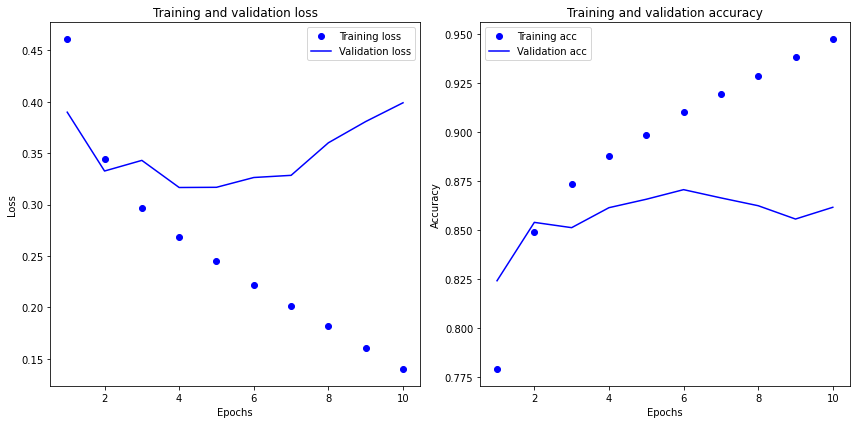

In [41]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Training and validation loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

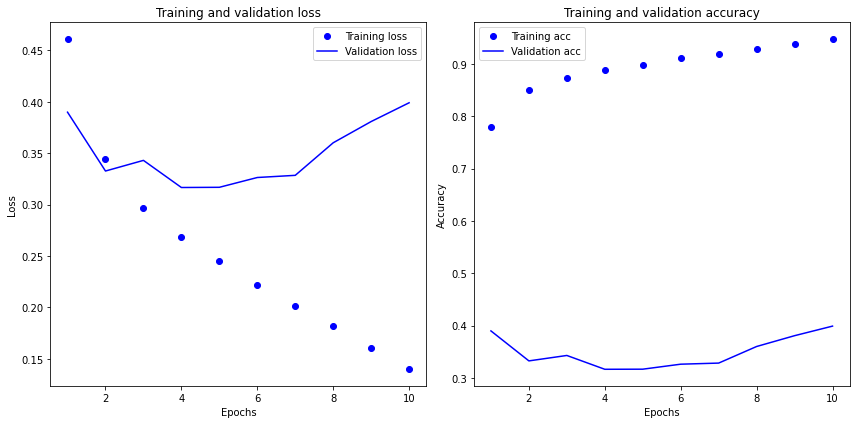

In [48]:
acc_2 = history_dict['accuracy']
val_acc_2 = history_dict['val_accuracy']
loss_2 = history_dict['loss']
val_loss_2 = history_dict['val_loss']

epochs_2 = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Training and validation loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_2, loss_2, 'bo', label='Training loss')
plt.plot(epochs_2, val_loss_2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_2, acc_2, 'bo', label='Training acc')
plt.plot(epochs_2, val_loss_2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

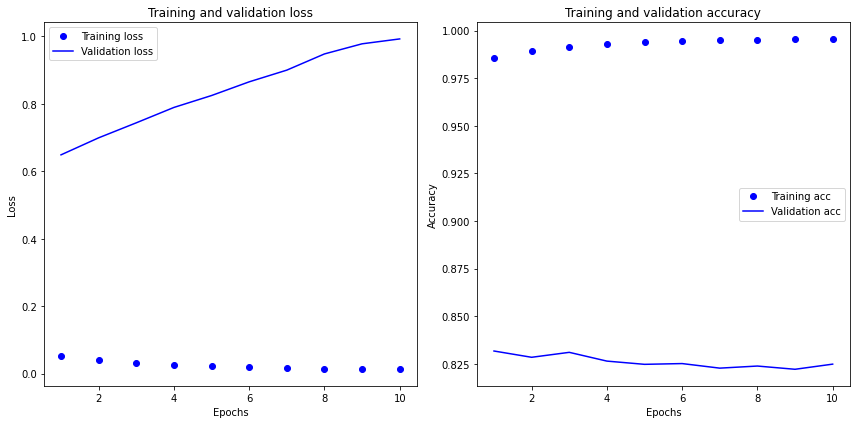

In [49]:
acc_3 = history_dict_3['accuracy']
val_acc_3 = history_dict_3['val_accuracy']
loss_3 = history_dict_3['loss']
val_loss_3 = history_dict_3['val_loss']

epochs_3 = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Training and validation loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_3, loss_3, 'bo', label='Training loss')
plt.plot(epochs_3, val_loss_3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_3, acc_3, 'bo', label='Training acc')
plt.plot(epochs_3, val_acc_3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 7) 학습된 Embedding 레이어 분석

In [15]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [19]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_exp4.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [20]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [31]:
vector = word_vectors['심']
vector

array([ 0.00416032,  0.04150696,  0.03773065,  0.01412844, -0.01000271,
        0.0036683 ,  0.01121166, -0.02700657,  0.04380243, -0.03378934,
       -0.03229302, -0.01699363, -0.03080411, -0.03489399, -0.04972962,
        0.00799438], dtype=float32)

In [32]:
word_vectors.similar_by_word("심")

[('시퀀스', 0.8413661122322083),
 ('드러난다', 0.8041055202484131),
 ('안나', 0.8001869320869446),
 ('갱', 0.7861826419830322),
 ('한국어', 0.7667194604873657),
 ('트리오', 0.7641676664352417),
 ('나나', 0.7498992681503296),
 ('은근', 0.7498953342437744),
 ('무자비', 0.7218629717826843),
 ('둔갑', 0.7156598567962646)]

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = './word2vec_ko.model'
word2vec = gensim.models.Word2Vec.load(word2vec_file_path)

In [35]:
word2vec.wv.similar_by_word("심")

[('박', 0.6017938256263733),
 ('화분', 0.5112336277961731),
 ('뒤집', 0.5054624676704407),
 ('내', 0.4981677532196045),
 ('집행유예', 0.49665898084640503),
 ('항소심', 0.49493345618247986),
 ('징역', 0.48781928420066833),
 ('품', 0.48483866453170776),
 ('심인', 0.4821106195449829),
 ('송심', 0.4811273217201233)]

In [22]:
import numpy as np
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [23]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   #trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 5s 12ms/step - loss: 0.4612 - accuracy: 0.7788 - val_loss: 0.3899 - val_accuracy: 0.8240
Epoch 2/10
266/266 [==============================] - 3s 10ms/step - loss: 0.3444 - accuracy: 0.8490 - val_loss: 0.3327 - val_accuracy: 0.8538
Epoch 3/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2971 - accuracy: 0.8734 - val_loss: 0.3430 - val_accuracy: 0.8511
Epoch 4/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2685 - accuracy: 0.8874 - val_loss: 0.3166 - val_accuracy: 0.8613
Epoch 5/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2454 - accuracy: 0.8985 - val_loss: 0.3168 - val_accuracy: 0.8656
Epoch 6/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2222 - accuracy: 0.9104 - val_loss: 0.3264 - val_accuracy: 0.8705
Epoch 7/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2009 - accuracy: 0.9191 - val_loss: 0.3285 - val_accuracy: 0.8663

In [25]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4061 - accuracy: 0.8578
[0.4060661494731903, 0.8578432202339172]


In [26]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


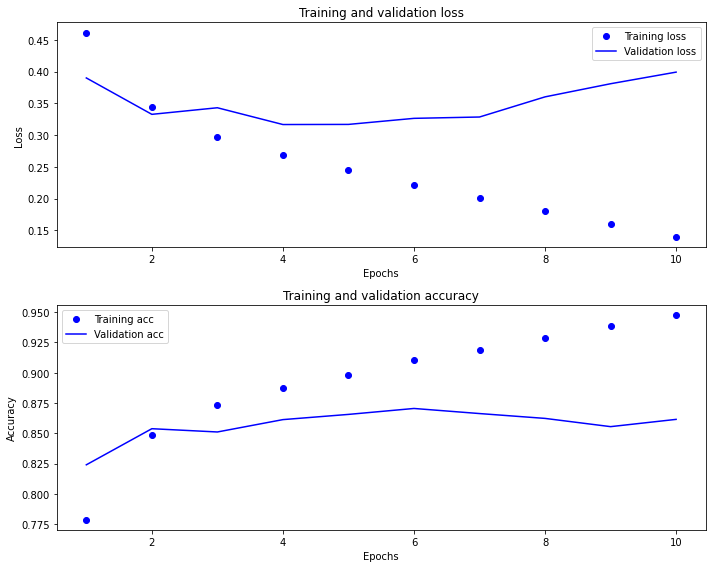

In [27]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 두 개의 축 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# 첫 번째 플롯: Loss
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# 두 번째 플롯: Accuracy
ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()  # 축간 간격 조정
plt.show()